# Polynomial Regression

**Topics Covered :**

- Polynomial Transformations :
    - Combinations with replacement
    - Creating new features out of the existing one using polynomial transformation
    
- Regularization Techniques :
    - Lasso (L1) Regularization
    - Ridge (L2) Regularization

- Updated `LinReg` class to include polynomial transformation and ridge regularization

( Lasso Regularization need advanced optimatization algorithms, so we use the `Lasso` module from `sklearn.linear_model` package)

In [3]:
import itertools
import functools
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore") 

## Combinations and Compute New Feature

In [21]:
def combinations(x, degree) :
    return itertools.combinations_with_replacement(x, degree)

def compute_new_features(items):
    return functools.reduce(lambda x, y: x * y, items)



x = [1, 2, 3, 4]
degree = 2
comb = list(combinations(x, degree))

for c in comb :
    print(c, " -> ", compute_new_features(c))

(1, 1)  ->  1
(1, 2)  ->  2
(1, 3)  ->  3
(1, 4)  ->  4
(2, 2)  ->  4
(2, 3)  ->  6
(2, 4)  ->  8
(3, 3)  ->  9
(3, 4)  ->  12
(4, 4)  ->  16


## Polynomial Transformation

In [50]:
def polynomial_transform(x, degree, logging=True) :
    if(x.ndim == 1) :
        x = x[:, None]
    
    features = [np.ones(len(x))]
    
    for degree in range(1, degree+1) :
        for item in combinations(x.T, degree) :
            if logging:
                print(item)
            features.append(compute_new_features(item))
    if logging:
        print(features)
    return np.asarray(features).T
    
    

In [55]:
# Here, in a single example, we have 2 and 3 as two weights and we want all combinations of degree 2.
print(polynomial_transform(np.array([[2, 3]]), 2))

# print(polynomial_transform(np.array([[2, 3],[4, 5]]), 2))
# print(polynomial_transform(np.array([[2, 3],[4, 5]]), 3))

(array([2]),)
(array([3]),)
(array([2]), array([2]))
(array([2]), array([3]))
(array([3]), array([3]))
[array([1.]), array([2]), array([3]), array([4]), array([6]), array([9])]
[[1. 2. 3. 4. 6. 9.]]


## Creating a Non-Linear Dataset and Visualizing It

In [61]:
def create_nonlin_training_set(func, sample_data, std) :
    x = np.linspace(0, 1, sample_data)
    y = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, y

def nonlin(x) :
    return np.sin(2 * np.pi * x)

def visualize_training_data(X_train, y_train):
    points = np.linspace(0, 1, 100)
    output = nonlin(points)
    
    plt.scatter(X_train, y_train, s=50, label="training data")
    plt.plot(points, output, c='g', label='$\sin(2 \pi x)$')
    
    plt.xlabel = "$x_1$"
    plt.ylabel = "y"
    plt.legend()
    plt.show()

def visualize_model_fit(X, y, lin_reg, degree):
    points = np.linspace(0, 1, 100)
    output = nonlin(points)
    
    if degree  > 0:
        plt.scatter(X, y, s=50, label="training data")
    plt.plot(points, output, c='g', label='$\sin(2 \pi x)$')

    # Predict function's second parameter is w. Here, we apply polynomial transformation to it before passing it on.
    y_hat = lin_reg.predict(polynomial_transform(points, degree,logging=False))
    plt.plot(points, y_hat, c='r', label='predicted')
    plt.xlabel = "$x_1$"
    plt.ylabel = "y"
    plt.legend()
#     plt.ylim(-1,5,1.5)
    plt.show()

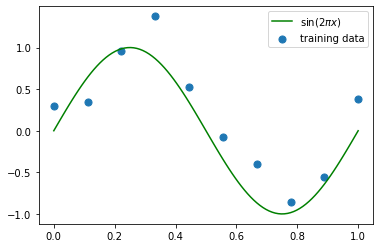

In [62]:
num_samples = 10
x, y = create_nonlin_training_set(nonlin, num_samples, 0.2)
visualize_training_data(x, y)

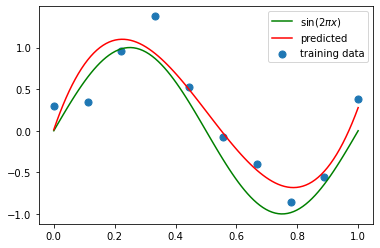

In [63]:
degree = 3
X_transform = polynomial_transform(x, degree,logging=False)
lin_reg = LinReg()
lin_reg.fit(X_transform, y)
visualize_model_fit(x, y, lin_reg, degree)

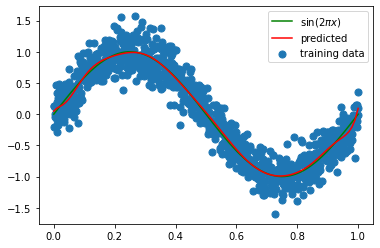

In [64]:
num_samples = 1000
x, y = create_nonlin_training_set(nonlin, num_samples, 0.2)

degree = 14
X_transform = polynomial_transform(x, degree,logging=False)
lin_reg = LinReg()
lin_reg.fit(X_transform, y)
visualize_model_fit(x, y, lin_reg, degree)

## Updated `LinReg` class

**Now includes Polynomial Transformation and Ridge (L2) Regularization**

The only changes are in the `fit()` function and in the `loss()` function

In [65]:
class LinReg():
    def __init__(self):
        self.t0 = 200
        self.t1 = 100000
    
    def predict (self, X):
        y = X @ self.w
        return y
    
    def loss (self, X, y):
        e = y - self.predict(X)
#       ---------------------------------------------------------------------------------------------------------------------
        
        return 0.5 *(e.T @ e) + (reg_rate/2) * (np.transpose(self.w) @ self.w)

#       ---------------------------------------------------------------------------------------------------------------------
    
    def rmse(self,X, y, reg_rate):
        return np.sqrt(2/X.shape[0] * self.loss(X, y, reg_rate))
    
    def fit(self, X, y, reg_rate):
        
#       ---------------------------------------------------------------------------------------------------------------------

#       self.w = np.linalg.pinv(X) @ y
        eye = np.eye(X.shape[1])
        self.w = np.linalg.solve(X.T @ X + reg_rate * eye, X.T @ y)

#       ---------------------------------------------------------------------------------------------------------------------
        return self.w
    
    def calculate_gradient(self, X, y, reg_rate):
        return X.T @ (self.predict(X) - y) + reg_rate * self.w
    
    def update_weights(self, grad, lr):
        return (self.w - lr * grad)
    
    def learning_schedule(self, t):
        return self.t0 / (self.t0 + self.t1)
    
    def gd(self, X, y, num_epochs, lr, reg_rate):
        self.w = np.zeros(X.shape[1])
        self.w_all = list() 
        self.err_all = list()
        for i in range(num_epochs):
            dJdw = self.calculate_gradient(X, y, reg_rate)
            self.w_all.append(self.w)
            self.err_all.append(self.loss(X, y, reg_rate))
            self.w = self.update_weights(dJdw, lr)
        return self.w
    
    def mbgd(self, X, y, num_epochs, batch_size):
        mini_batch_id = 0
        self.w = np.zeros(X.shape[1]) 
        self.w_all = list() 
        self.err_all = list()

        for epoch in range(num_epochs):
            shuffled_indices = np.random.permutation(X.shape[0])
            X_shuffled = X[shuffled_indices]
            y_shuffled = y[shuffled_indices]

            for i in range(0, X.shape[0], batch_size):
                mini_batch_id += 1
                x1 = X_shuffled[i:i+batch_size]
                y1 = y_shuffled[i:i+batch_size]

                self.w_all.append(self.w)
                self.err_all.append(self.loss(X, y))

                dJdw = 2/batch_size * self.calculate_gradient(x1, y1)
                self.w = self.update_weights(dJdw, self.learning_schedule(mini_batch_id))

        return self.w
    
    def sgd(self, X, y, num_epochs):
        batch_size = 1
        mini_batch_id = 0
        self.w = np.zeros(X.shape[1])  
        self.w_all = list() 
        self.err_all = list()

        for epoch in range(num_epochs):
            shuffled_indices = np.random.permutation(X.shape[0])
            X_shuffled = X[shuffled_indices]
            y_shuffled = y[shuffled_indices]

            for i in range(0, X.shape[0], batch_size):
                mini_batch_id += 1
                x1 = X_shuffled[i:i+batch_size]
                y1 = y_shuffled[i:i+batch_size]

                self.w_all.append(self.w)
                self.err_all.append(self.loss(X, y))

                dJdw = 2/batch_size * self.calculate_gradient(x1, y1)
                self.w = self.update_weights(dJdw, self.learning_schedule(mini_batch_id))

        return self.w

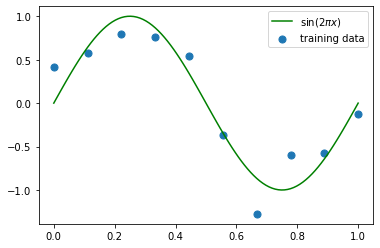

In [66]:
num_samples = 10
x, y = create_nonlin_training_set(nonlin, num_samples, 0.2)
visualize_training_data(x, y)

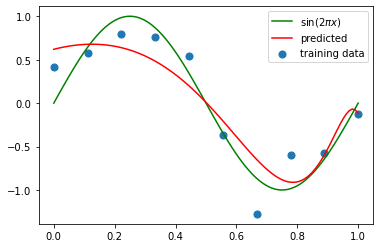

In [69]:
reg_rate = 0.01
degree = 20

X_transform = polynomial_transform(x, degree,logging=False)
lin_reg = LinReg()
lin_reg.fit(X_transform, y, reg_rate)
visualize_model_fit(x, y, lin_reg, degree)

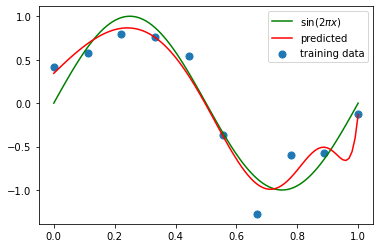

In [70]:
reg_rate = 0.0001
degree = 20

X_transform = polynomial_transform(x, degree,logging=False)
lin_reg = LinReg()
lin_reg.fit(X_transform, y, reg_rate)
visualize_model_fit(x, y, lin_reg, degree)



## Evaluation - Visualizing Training and Validation Loss

In [74]:
def plot_learning_curves(losses):
    plt.plot(losses)

In [72]:
#Create the training set
num_samples = 10
x, y = create_nonlin_training_set(nonlin, num_samples, 0.2)

#Transform it
degree = 9
X_transform = polynomial_transform(x, degree,logging=False)

#Create the validation set
x_val = np.linspace(0, 1, 100)
y_val = nonlin(x_val)

#Transform it
degree = 9
X_val_transform = polynomial_transform(x_val, degree,logging=False)

In [77]:
w_dict = dict()
training_errors = dict()
val_errors = dict()

for reg_rate in [10,1,0.1,0.01,0.001, 0.0001]:
    lin_reg = LinReg()
    
    #Find the rmse for training set.
    lin_reg.fit(X_transform, y, reg_rate)
    w_dict[reg_rate] = lin_reg.w
    training_errors[reg_rate] = lin_reg.rmse(X_transform, y, reg_rate)
    
    #Find the rmse for validation set
    lin_reg.fit(X_val_transform, y_val, reg_rate)
    val_errors[reg_rate] = lin_reg.rmse(X_val_transform, y_val + np.random.normal(scale=0.25, size=len(y_val)), reg_rate)

err_df = pd.DataFrame([training_errors, val_errors], index=['Training errors', 'Validation Errors']).T
w_df = pd.DataFrame(w_dict)

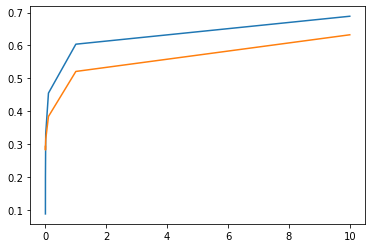

In [78]:
plot_learning_curves(err_df)

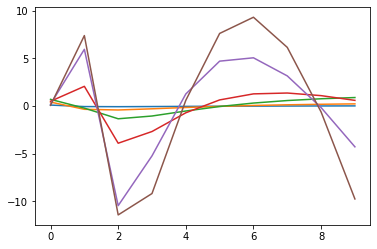

In [79]:
plot_learning_curves(w_df)

## Lasso (L1) Regularization Test

In [81]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

w_dict = dict()
training_errors = dict()
val_errors = dict()

for reg_rate in [10,1,0.1,0.01,0.001, 0.0001]:
    lasso = Lasso(alpha=reg_rate)
    lasso.fit(X_transform, y)

    w_dict[reg_rate] = lasso.coef_

    training_errors[reg_rate] = mean_squared_error(y, lasso.predict(X_transform))
    val_errors[reg_rate] = mean_squared_error(y_val + np.random.normal(scale=0.25, size=len(y_val)), 
                                                             lasso.predict(X_val_transform))

err_df = pd.DataFrame([training_errors, val_errors], index=['Training errors', 'Validation Errors']).T
w_df = pd.DataFrame(w_dict)

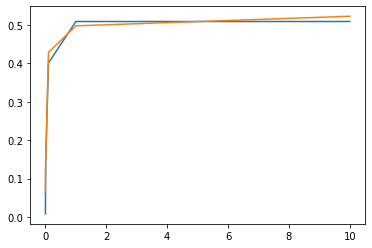

In [82]:
plot_learning_curves(err_df)

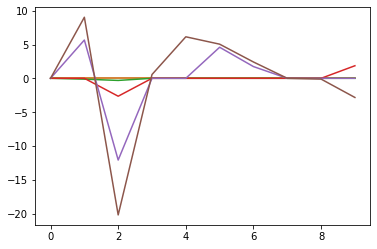

In [83]:
plot_learning_curves(w_df)

## Ridge (L2) Regularization Test


In [84]:
from sklearn.datasets import make_regression
X, y, w = make_regression(n_samples=100, n_features=10, n_informative=10, 
                bias=1, n_targets=5, shuffle=True, coef=True, random_state=42)

In [85]:
def add_dummy_feature(x):
    return np.column_stack((np.ones(x.shape[0]), x))

def preprocess(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train = add_dummy_feature(X_train)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess(X, y)

In [90]:
lin_reg = LinReg()
w_fit = lin_reg.fit(X_train, y_train, 0)
w_fit.shape
# np.testing.assert_almost_equal(w, w_fit[1:, :], decimal=2)

(11, 5)

In [92]:
w_gd = lin_reg.gd(X_train, y_train, num_epochs=100, lr=0.01, reg_rate=0)
w_gd.shape
# np.testing.assert_almost_equal(w_gd, w_fit, decimal=2)

(11, 5)

### Doubts and Clarification

In [35]:
x = np.array([1,2,3,4])
print(x.ndim)

x = np.array([[1,2,3,4], [1,2,3,5]])
print(x.ndim)

x = np.zeros((3,2,2))
print(x.ndim)
print(x)

1
2
3
[[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]]
